# Cost Prediction for Logistic Company

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

- Questions to consider:

    - Who are your stakeholders?
        - Shippers and recievers 
    - What are your stakeholders' pain points related to this project?
        - 
    - Why are your predictions important from a business perspective?
        - The predictions are important 
    - What exactly is your deliverable: your analysis, or the model itself?
        - 
    - Does your business understanding/stakeholder require a specific type of model?
        - 
        - For example: a highly regulated industry would require a very transparent/simple/interpretable model, whereas a situation where the model itself is your deliverable would likely benefit from a more complex and thus stronger model
- Additional questions to consider for classification:

    - What does a false positive look like in this context?
    - What does a false negative look like in this context?
    - Which is worse for your stakeholder?
    - What metric are you focusing on optimizing, given the answers to the above questions?

## Imports

In [313]:
import numpy as np 
import pandas as pd
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import xgboost as xgb

from datetime import datetime
from time import strftime

from sklearn import utils, preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder,  MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

### Exploring data

In [314]:
!ls ../data/

test.csv  train.csv


In [315]:
# setting data to variable 
df = pd.read_csv('../data/train.csv', parse_dates=['date'])

In [316]:
# Beginning amount of df rows
len(df)

38999

In [317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   trip                 38999 non-null  object        
 1   date                 38999 non-null  datetime64[ns]
 2   dayPart              38999 non-null  object        
 3   exWeatherTag         4882 non-null   object        
 4   originLocation       38999 non-null  object        
 5   destinationLocation  38999 non-null  object        
 6   distance             38999 non-null  int64         
 7   type                 3748 non-null   object        
 8   weight               38999 non-null  int64         
 9   packageType          2500 non-null   object        
 10  carrier              38999 non-null  object        
 11  cost                 38999 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 3.6+ MB


In [318]:
df['cost']

0        68.413152
1        36.450649
2         9.057939
3        57.320087
4        77.263777
           ...    
38994    14.987239
38995    33.214738
38996    45.172159
38997    47.541427
38998    68.054098
Name: cost, Length: 38999, dtype: float64

<AxesSubplot:ylabel='Frequency'>

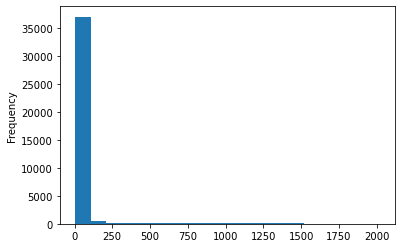

In [319]:
df['cost'].plot(kind='hist', bins=20)

In [320]:
df['cost'].describe()

count    38999.000000
mean        80.972210
std        180.715055
min          5.000000
25%         38.768742
50%         46.468476
75%         70.239797
max       2019.734797
Name: cost, dtype: float64

In [321]:
df['trip'].keys()

RangeIndex(start=0, stop=38999, step=1)

In [322]:
df

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NaN,43,NaN,B,77.263777
...,...,...,...,...,...,...,...,...,...,...,...,...
38994,t11845608590,2019-10-17,night,NaN,S3,D3,1200,NaN,3,NaN,B,14.987239
38995,t53557166488,2019-01-23,night,NaN,S4,D6,2000,NaN,6,NaN,B,33.214738
38996,t337474787136,2018-10-03,night,NaN,S8,D7,3000,NaN,24,NaN,B,45.172159
38997,t76488353326,2018-02-26,night,NaN,S8,D5,2600,NaN,31,NaN,B,47.541427


## Data Engineering

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
    - Dropped : 'exWeatherTag'
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

In [323]:
df['exWeatherTag'].value_counts()

snow    3286
heat    1596
Name: exWeatherTag, dtype: int64

In [324]:
df['exWeatherTag'].value_counts()

snow    3286
heat    1596
Name: exWeatherTag, dtype: int64

In [325]:
# converting values in clean_df['exWeatherTag'] into binary
# df.dayPart[df.dayPart == 'Nan'] = 0
# df.dayPart[df.dayPart == 'day'] = 1
# df.dayPart[df.dayPart == 'day'] = 2

In [326]:
# dropping columns
clean_df = df.drop(columns=['exWeatherTag', 'type', 'packageType'])

In [327]:
# code here to prepare your data

In [328]:
# removing 't' from trip column
clean_df['trip'] = clean_df["trip"].str[1:]

In [329]:
# Turning values in clean_df['dayPart'] to binary

In [330]:
clean_df['dayPart'].value_counts()

night    25904
day      13095
Name: dayPart, dtype: int64

In [331]:
clean_df['originLocation'].unique()

array(['S4', 'S8', 'S9', 'S6', 'S7', 'S3', 'S5', 'S1', 'S2'], dtype=object)

In [332]:
clean_df['originLocation'].value_counts()

S3    4461
S5    4388
S6    4379
S8    4368
S4    4324
S1    4312
S9    4302
S7    4267
S2    4198
Name: originLocation, dtype: int64

In [333]:
# Turning values in clean_df['originLocation'] to numeric

In [334]:
clean_df['destinationLocation'].unique()

array(['D7', 'D1', 'D5', 'D4', 'D2', 'D9', 'D6', 'D3', 'D8'], dtype=object)

In [335]:
clean_df['destinationLocation'].value_counts().D7

4297

In [336]:
# Turning values in clean_df['destinationLocation'] to numeric

In [337]:
#clean_df['packageType'].unique()

In [338]:
# Turning values in clean_df['packageType'] to binary
#clean_df.packageType[clean_df.packageType == 'nan'] = 0
#clean_df.packageType[clean_df.packageType == 'TT'] = 1

In [339]:
clean_df['carrier'].unique()

array(['D', 'B', 'C', 'A'], dtype=object)

In [340]:
# clean_df ['carrier'] into numeric

In [341]:
clean_df['dayPart']

0        night
1        night
2        night
3          day
4          day
         ...  
38994    night
38995    night
38996    night
38997    night
38998    night
Name: dayPart, Length: 38999, dtype: object

In [342]:
clean_df['month'] = clean_df['date'].dt.month

In [343]:
X_train.dtypes

dayPart                object
originLocation         object
destinationLocation    object
distance                int64
weight                  int64
carrier                object
month                   int64
dtype: object

### Train test split

In [344]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   trip                 38999 non-null  object        
 1   date                 38999 non-null  datetime64[ns]
 2   dayPart              38999 non-null  object        
 3   originLocation       38999 non-null  object        
 4   destinationLocation  38999 non-null  object        
 5   distance             38999 non-null  int64         
 6   weight               38999 non-null  int64         
 7   carrier              38999 non-null  object        
 8   cost                 38999 non-null  float64       
 9   month                38999 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 3.0+ MB


In [345]:
X = clean_df.drop(columns=['trip','cost', 'date'])
y = clean_df['cost']

In [346]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size = .2)

In [347]:
y_train.describe()
# predicting for cost of 1000s of dollar

count    31199.000000
mean        80.391868
std        178.244806
min          5.000000
25%         38.861952
50%         46.427799
75%         70.193598
max       2006.016001
Name: cost, dtype: float64

In [348]:
# one hot encoding weight and distance
# pipeline for daypart, originlocation, destinationlocation,carrier, month
obj_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

In [349]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [350]:
col_transformer = ColumnTransformer(transformers=[
    ('num_trans', num_transformer, ['distance', 'weight']),
    ('obj_trans', obj_transformer, ['dayPart', 'originLocation', 'destinationLocation', 'carrier', 'month'])
])

In [351]:
#Exploring target column breakdown
len(y_train.value_counts())

3500

In [352]:
y_train.head()

12709    13.771838
37727    63.000000
31410    70.323333
13135    70.008247
34243    14.631378
Name: cost, dtype: float64

In [353]:
X_cols = list(X_train.columns)

In [354]:
X_cols

['dayPart',
 'originLocation',
 'destinationLocation',
 'distance',
 'weight',
 'carrier',
 'month']

In [355]:
pd.DataFrame(X_train_sc, columns=X_train.columns)

,dayPart,originLocation,destinationLocation,distance,weight,carrier,month
0,1.406565,-0.003123,-0.776720,-0.552831,-0.521281,-0.301520,-1.592873
1,-0.710952,0.773141,-0.004591,0.541918,-0.521281,2.579682,1.016467
2,-0.710952,-0.003123,-0.776720,-0.552831,0.038259,2.579682,1.016467
3,1.406565,1.161273,-0.776720,0.268231,-0.121610,-0.301520,-0.143240
4,-0.710952,-1.167518,1.539668,0.268231,-0.521281,-0.301520,0.146687
...,...,...,...,...,...,...,...
31194,1.406565,1.549405,-1.162785,0.268231,0.091548,-0.301520,1.016467
31195,-0.710952,1.161273,1.153604,1.636668,-0.467991,-0.301520,-1.592873
31196,-0.710952,-1.555650,1.539668,-0.005456,-0.108287,-0.301520,-0.433166
31197,-0.710952,1.549405,1.539668,2.184042,2.702732,1.139081,-0.433166


In [356]:
for col in X_cols:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

ValueError: invalid literal for int() with base 10: 'day'

In [357]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31199 entries, 12709 to 15795
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dayPart              31199 non-null  object
 1   originLocation       31199 non-null  object
 2   destinationLocation  31199 non-null  object
 3   distance             31199 non-null  int64 
 4   weight               31199 non-null  int64 
 5   carrier              31199 non-null  object
 6   month                31199 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.9+ MB


## Exploring relationship between two variables

In [358]:
clean_df.head()

,trip,date,dayPart,originLocation,destinationLocation,distance,weight,carrier,cost,month
0,52712528,2017-09-06,night,S4,D7,2200,50,D,68.413152,9
1,29859381,2017-10-21,night,S8,D1,1800,12,B,36.450649,10
2,25702332,2017-07-15,night,S9,D5,2800,1,B,9.057939,7
3,27713405,2017-10-22,day,S9,D7,3200,50,C,57.320087,10
4,49439220,2019-12-11,day,S9,D1,2000,43,B,77.263777,12


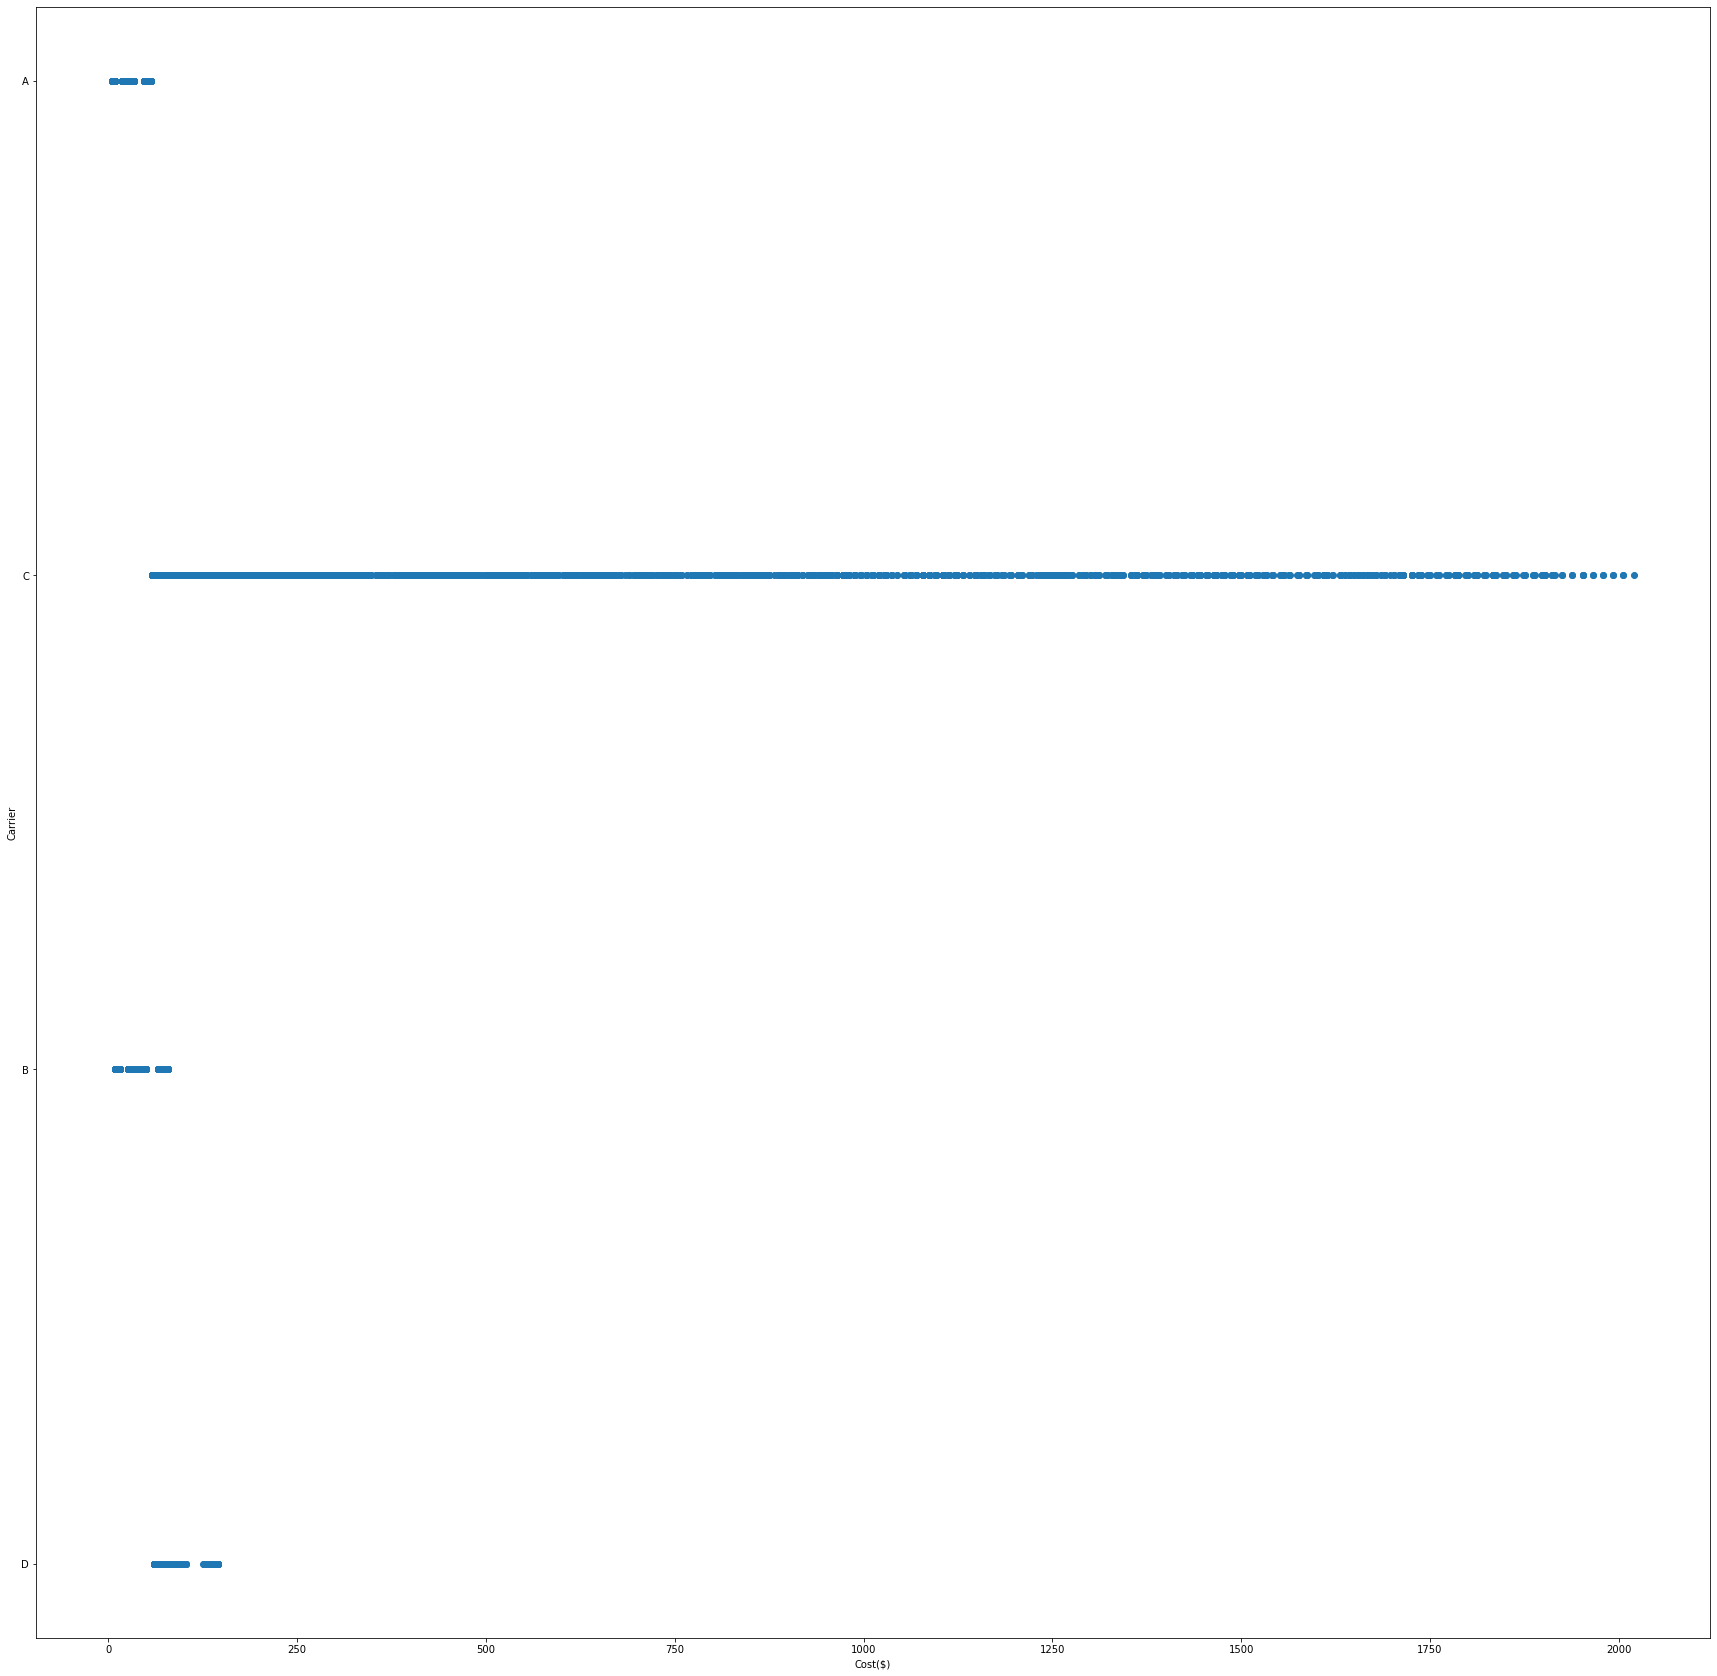

In [359]:
# can use a scatter plot to explore relationship between 2 variables
plt.figure(figsize=(30,30))

plt.scatter(clean_df['cost'], clean_df['carrier'])
plt.ylabel('Carrier')
plt.xlabel('Cost($)')
plt.show()

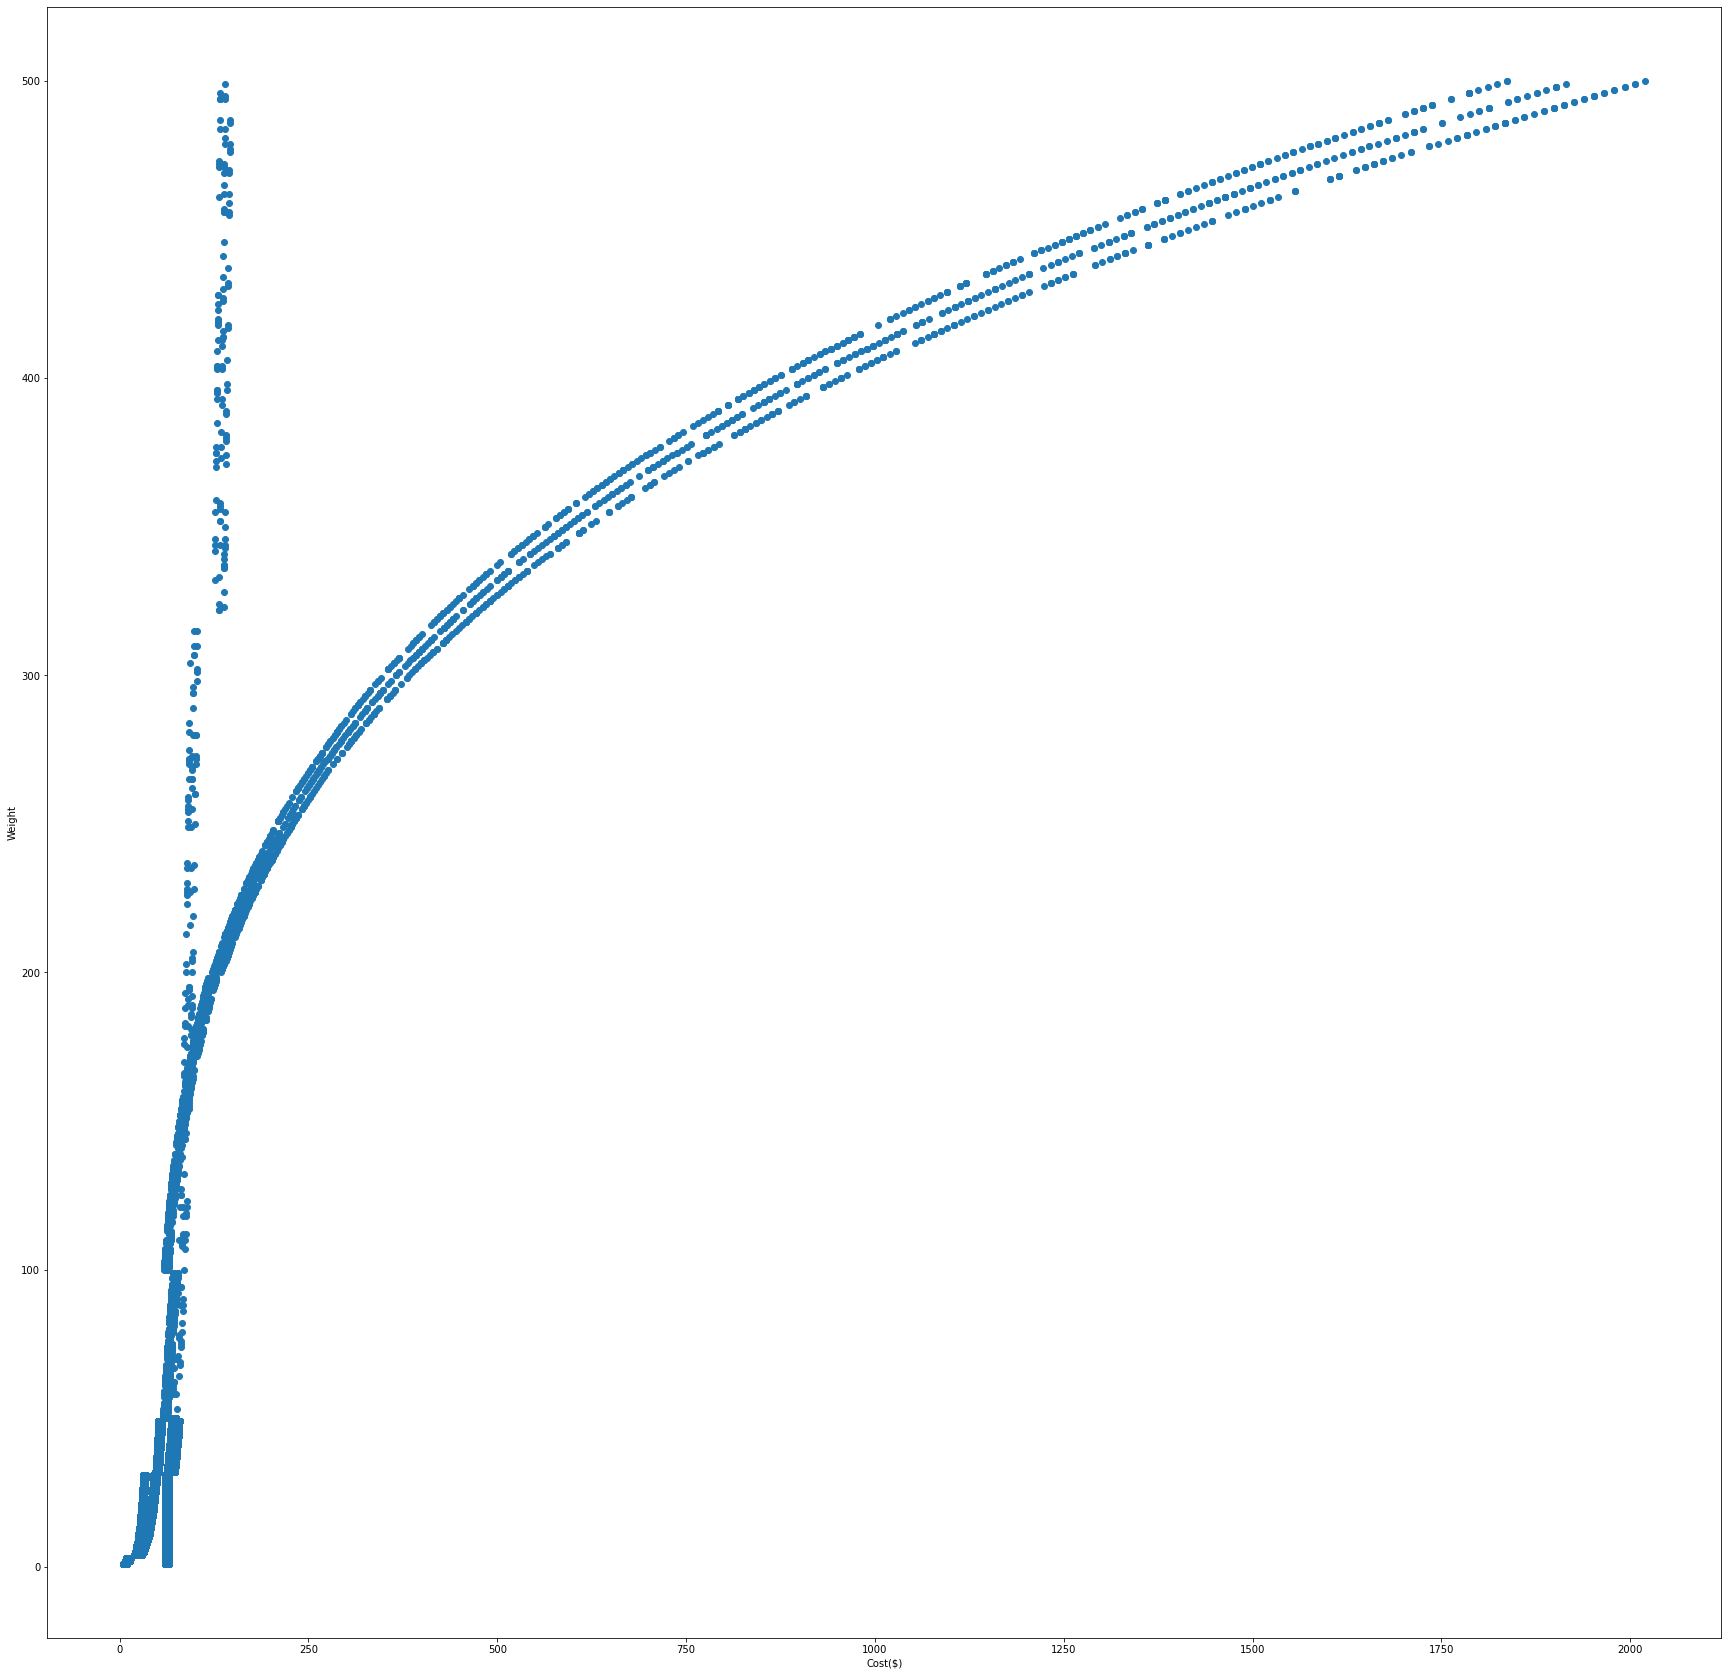

In [360]:
# can use a scatter plot to explore relationship between 2 variables
plt.figure(figsize=(30,30))

plt.scatter(clean_df['cost'], clean_df['weight'])
plt.ylabel('Weight')
plt.xlabel('Cost($)')
plt.show()

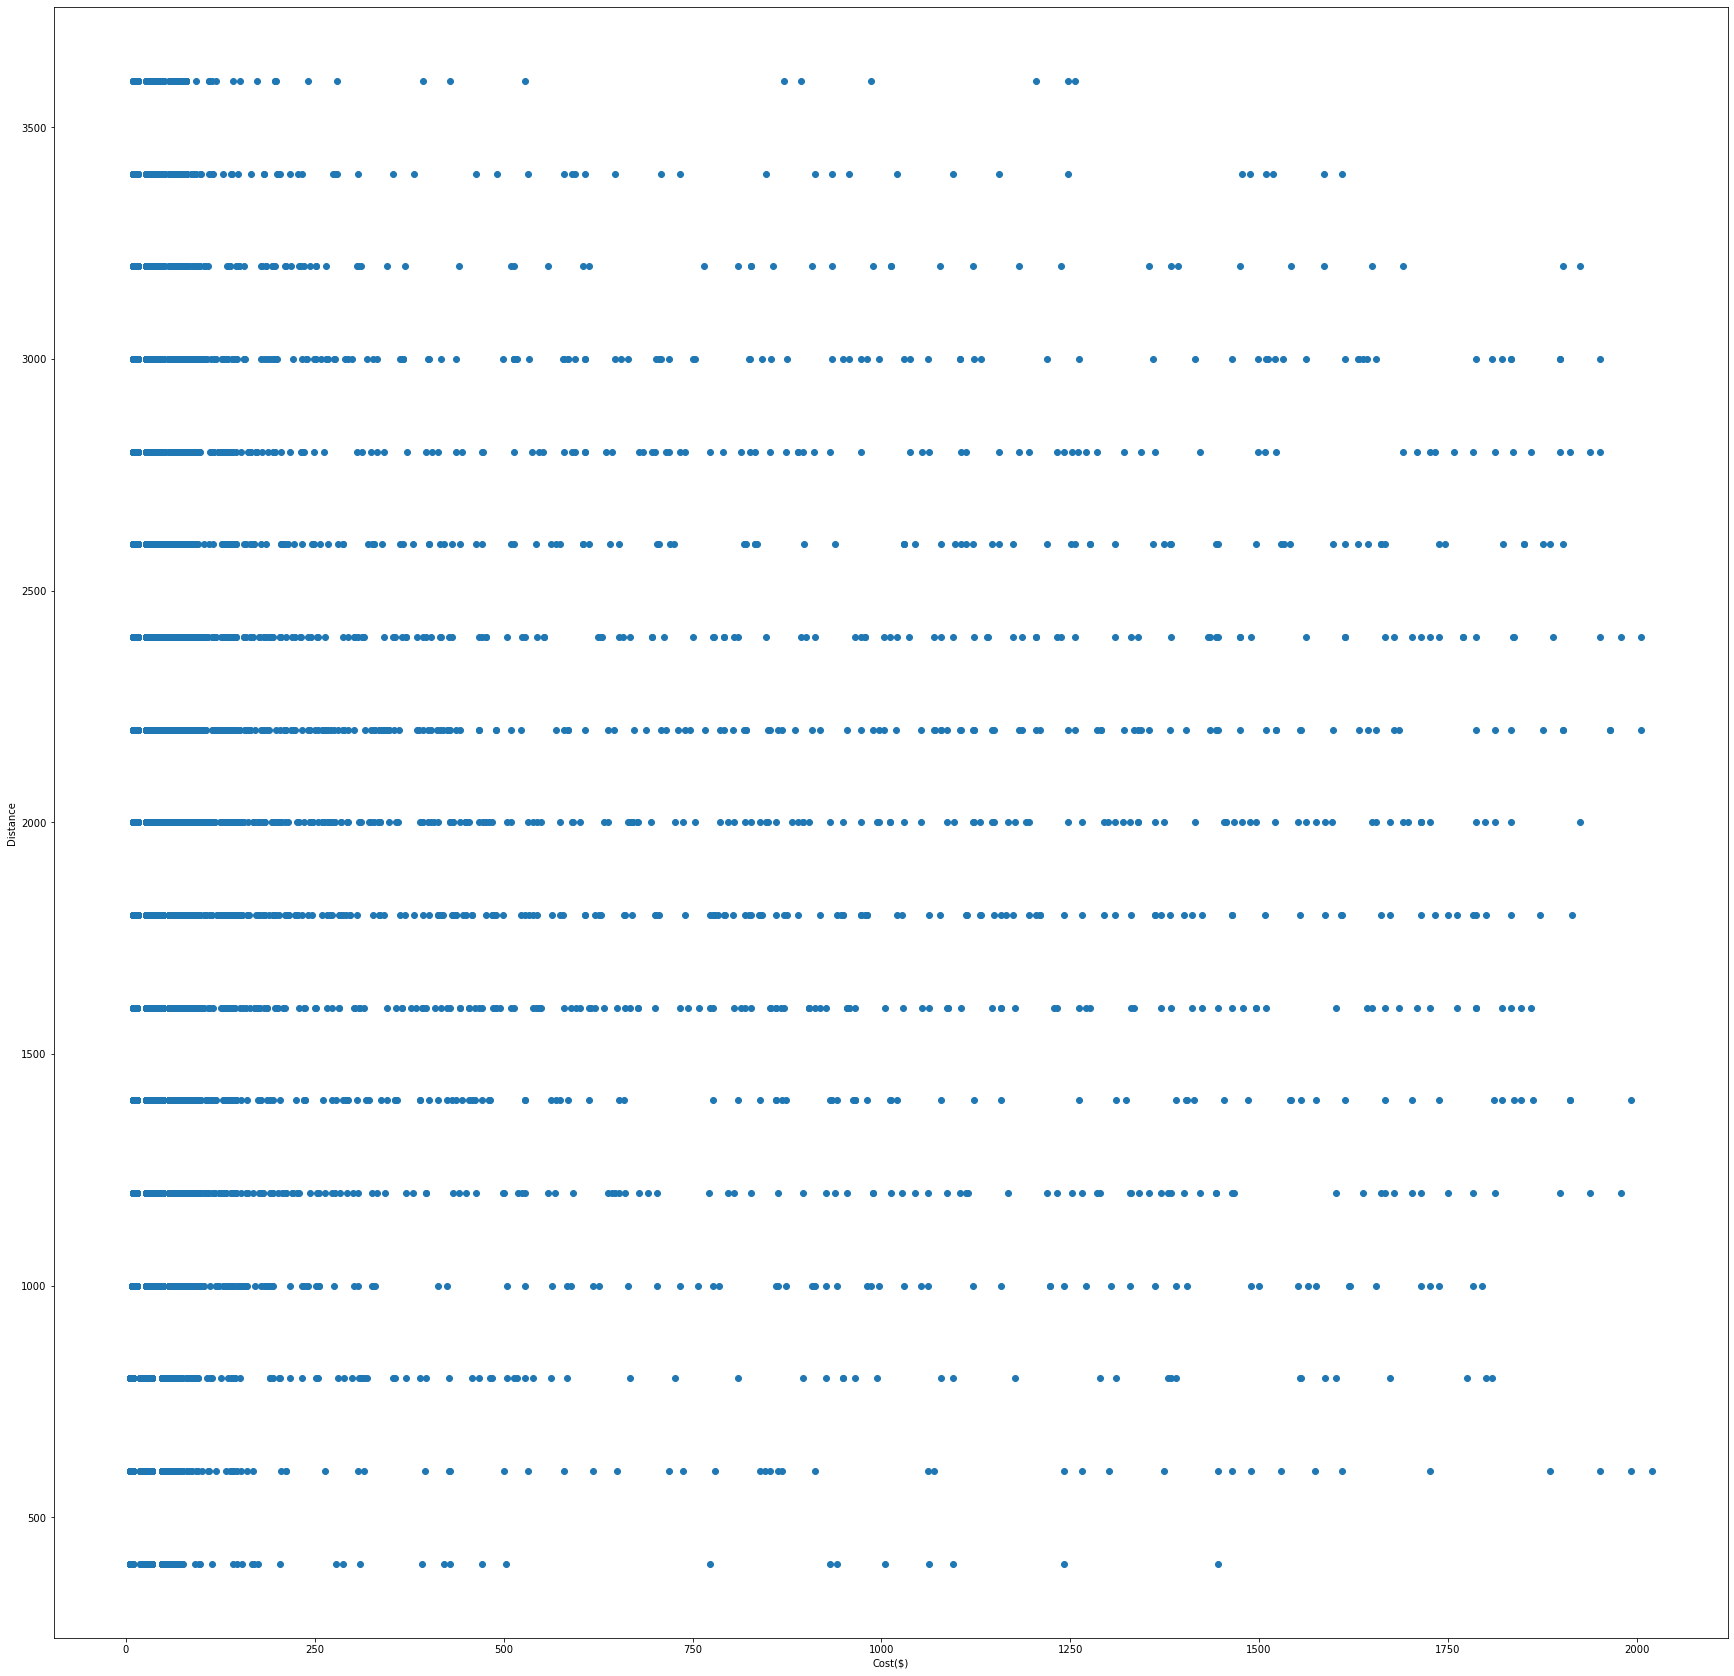

In [361]:
# can use a scatter plot to explore relationship between 2 variables
plt.figure(figsize=(30,30))

plt.scatter(clean_df['cost'], clean_df['distance'])
plt.ylabel('Distance')
plt.xlabel('Cost($)')
plt.show()

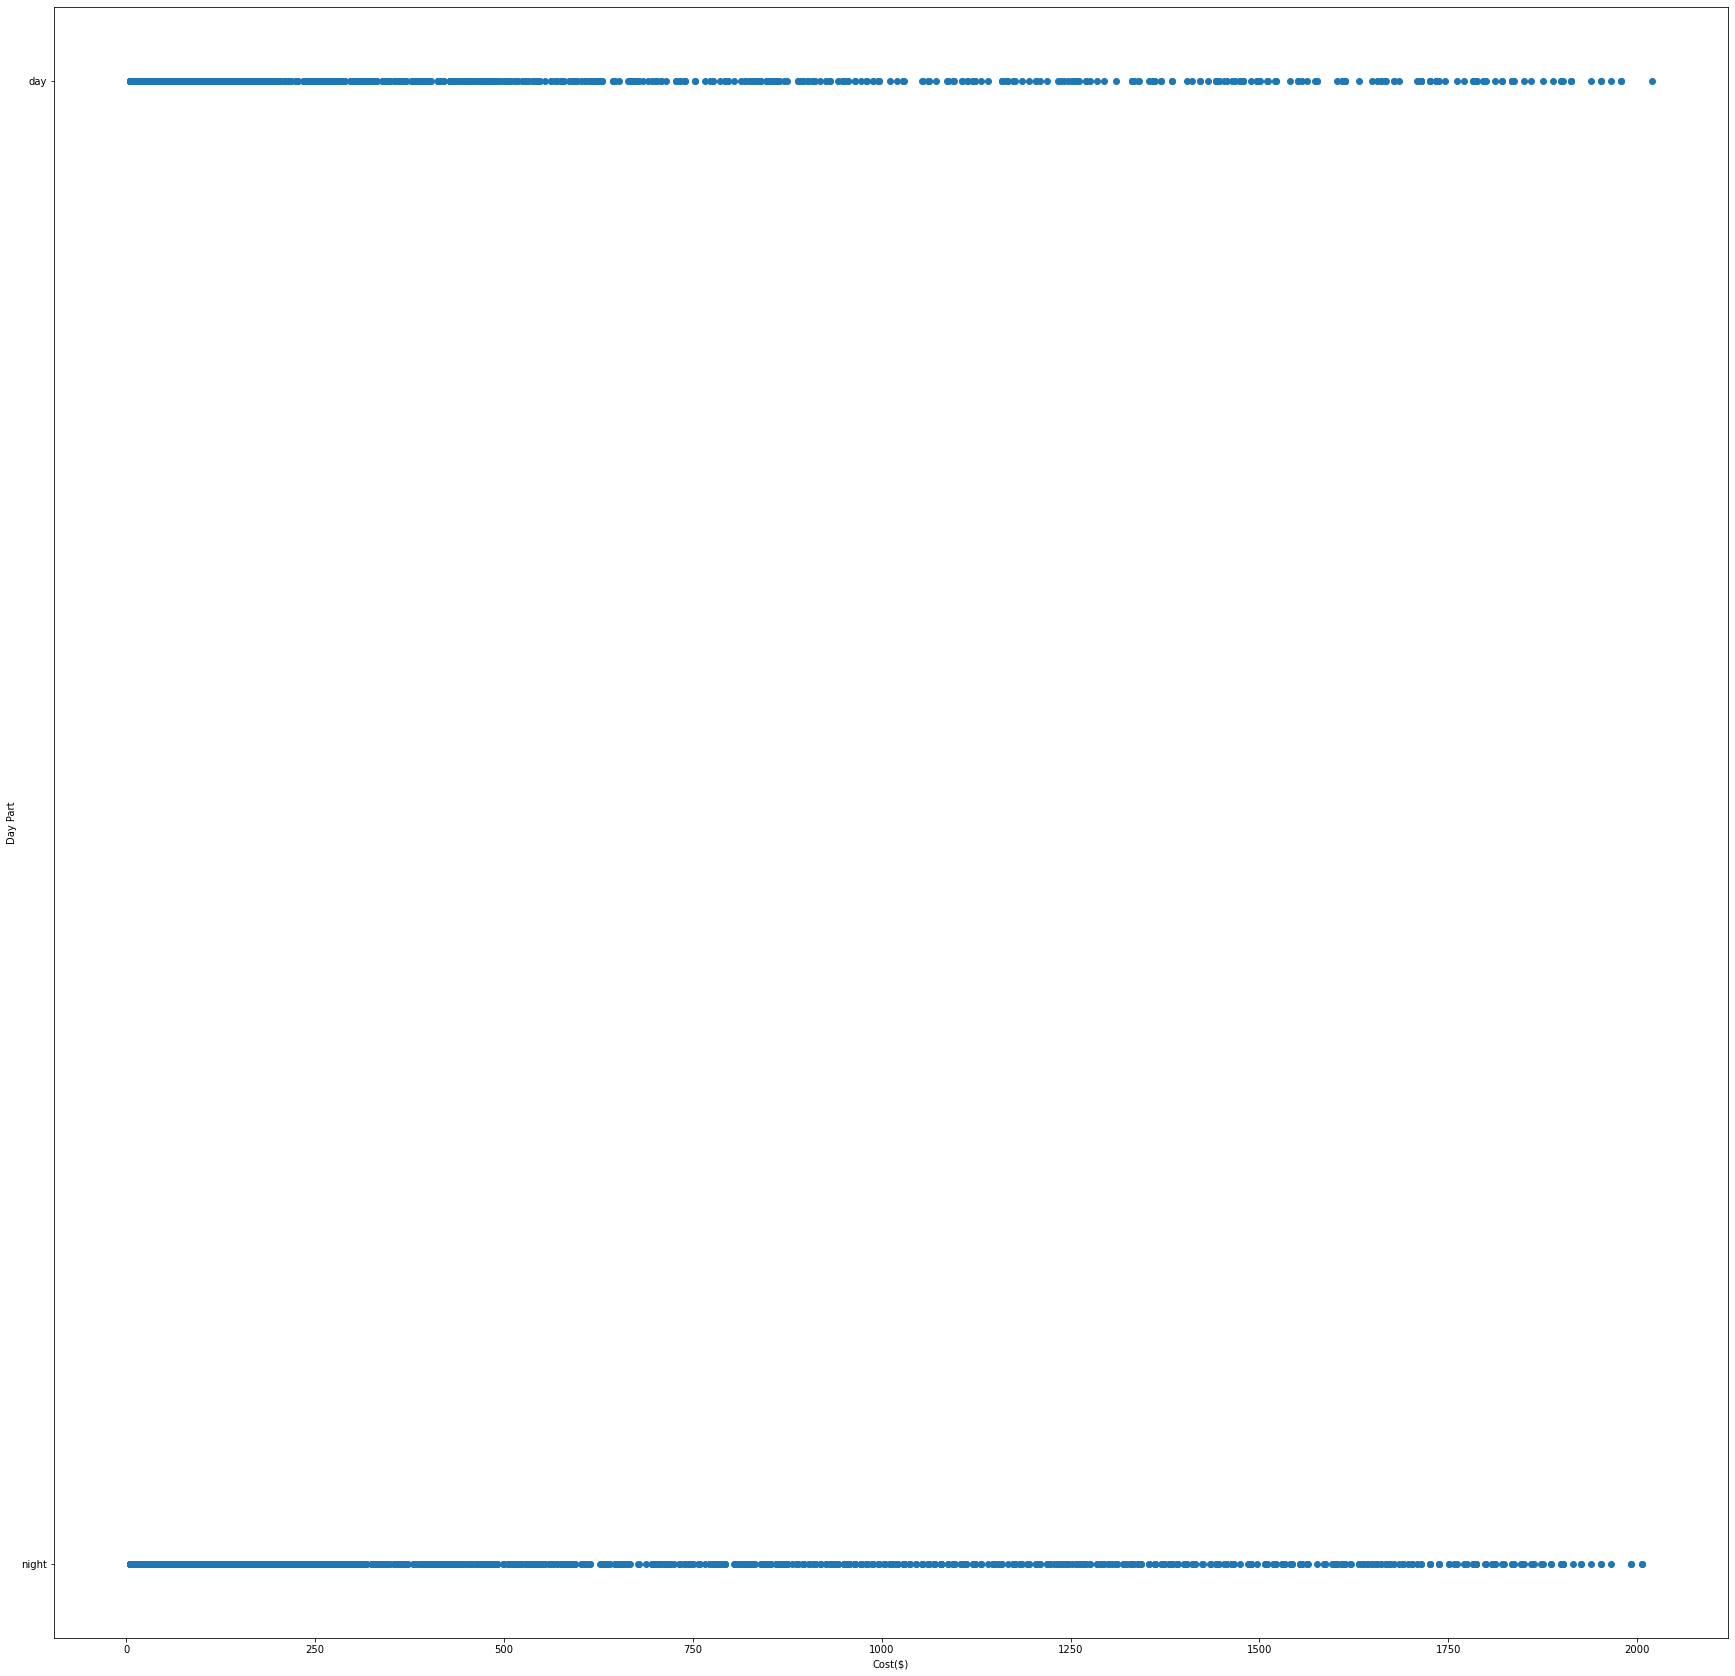

In [362]:
# can use a scatter plot to explore relationship between 2 variables
plt.figure(figsize=(30,30))

plt.scatter(clean_df['cost'], clean_df['dayPart'])
plt.ylabel('Day Part')
plt.xlabel('Cost($)')
plt.show()

## Modeling

In [363]:
#checking correlations using Pearson correlation coefficient
X.corr()

,distance,weight,month
distance,1.000000,-0.004986,0.000988
weight,-0.004986,1.000000,-0.003634
month,0.000988,-0.003634,1.000000


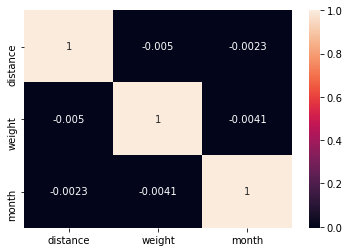

In [364]:
# Heat map
sns.heatmap(X_train.corr(), annot=True)
plt.show()

In [365]:
clean_df.corr()['cost'].map(abs).sort_values(ascending=False)

cost        1.000000
weight      0.859548
month       0.008062
distance    0.006427
Name: cost, dtype: float64

In [366]:
# Instantiate our model
lr_all = LinearRegression()

# Run with all features
lr_all.fit(X_train_sc, y_train)

# Score on train and test
print(f"Train R2: {lr_all.score(X_train_sc, y_train):.4f}")
print(f"Test R2: {lr_all.score(X_test_sc, y_test):.4f}")

Train R2: 0.7393
Test R2: 0.7472


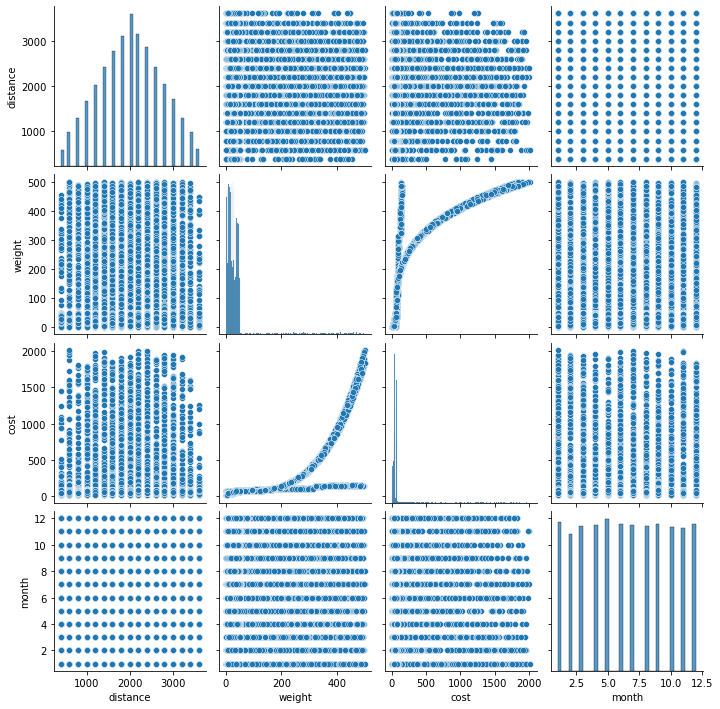

In [367]:
# check for linearity and multicollinearity at the same time
sns.pairplot(clean_df)
plt.show()

### Linear reg model

In [368]:
# #converting df['carrier'] values to categorical values
# lab = preprocessing.LabelEncoder()
# y_transformed = lab.fit_transform(y)

# #view transformed values
# print(y_transformed) 

# #https://www.statology.org/valueerror-unknown-label-type-continuous/

In [369]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31199 entries, 12709 to 15795
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dayPart              31199 non-null  object
 1   originLocation       31199 non-null  object
 2   destinationLocation  31199 non-null  object
 3   distance             31199 non-null  int64 
 4   weight               31199 non-null  int64 
 5   carrier              31199 non-null  object
 6   month                31199 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.9+ MB


In [370]:
# lab_enc = preprocessing.LabelEncoder()
# encoded = lab_enc.fit_transform(y_train)

In [371]:
linreg_pipe = Pipeline(steps=[
    ('col_trans', col_transformer),
    ('linreg', LinearRegression())
])

In [372]:
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'weight']),
                                                 ('obj_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dayPart', 'originLocation',
                                                   'destinationLocation',
                                                   'carrier', 'month'])])),
                ('linreg', LinearRegression())])

In [373]:
y_hat_train = linreg_pipe.predict(X_train)
# Make predictions on the test set

y_hat_test = linreg_pipe.predict(X_test)
# https://ittutoria.net/question/unknown-label-type-continuous/

In [374]:
# Evaluate: use .score to check accuracy on train and test
linreg_pipe.score(X_train, y_train)

0.7470071996878904

In [375]:
linreg_pipe.score(X_test, y_test)

0.7552069864234622

In [376]:
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Train RMSE: {mean_squared_error(y_train, y_hat_train, squared=False)}')
print('-------------------')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_hat_test, squared=False)}')

Train R2: 0.7470071996878904
Train RMSE: 89.65283026830319
-------------------
Test R2: 0.7552069864234622
Test RMSE: 94.13278154899274


### Decision Tree 1

In [377]:
dt_pipe = Pipeline(steps=[
    ('col_trans', col_transformer),
    ('dt', DecisionTreeRegressor())
])

In [378]:
# Instantiate and fit 


dt_pipe.fit(X_train, y_train)

y_hat_train = dt_pipe.predict(X_train)
# Make predictions on the test set

y_hat_test = dt_pipe.predict(X_test)

In [379]:
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Train RMSE: {mean_squared_error(y_train, y_hat_train, squared=False)}')
print('-------------------')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_hat_test, squared=False)}')

Train R2: 0.9999843558399417
Train RMSE: 0.7049950191686595
-------------------
Test R2: 0.996503102393352
Test RMSE: 11.250785387076835


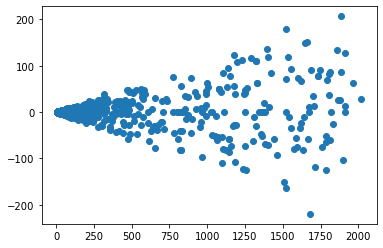

In [380]:
plt.scatter(y_test, (y_test - y_hat_test))

### Decision Tree 2

In [381]:
dt_pipe2 = Pipeline(steps=[
    ('col_trans', col_transformer),
    ('dt', DecisionTreeRegressor(max_depth=8))
])

In [382]:
# Instantiate and fit 


dt_pipe2.fit(X_train, y_train)

y_hat_train = dt_pipe2.predict(X_train)
# Make predictions on the test set

y_hat_test = dt_pipe2.predict(X_test)

In [383]:
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Train RMSE: {mean_squared_error(y_train, y_hat_train, squared=False)}')
print('-------------------')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_hat_test, squared=False)}')

Train R2: 0.9986328694405819
Train RMSE: 6.590447715371685
-------------------
Test R2: 0.9974545899950837
Test RMSE: 9.598873226254854


### Random forest

In [384]:
rf_pipe = Pipeline(steps=[
    ('col_trans', col_transformer),
    ('rf', RandomForestRegressor())
])

In [385]:
# Instantiate and fit 


rf_pipe.fit(X_train, y_train)

y_hat_train = rf_pipe.predict(X_train)
# Make predictions on the test set

y_hat_test = rf_pipe.predict(X_test)

In [169]:
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Train RMSE: {mean_squared_error(y_train, y_hat_train, squared=False)}')
print('-------------------')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_hat_test, squared=False)}')

Train R2: 0.9996824771786472
Train RMSE: 3.176123607114595
-------------------
Test R2: 0.9977161098506707
Test RMSE: 9.092409523818326


In [290]:
X_cols

['dayPart',
 'originLocation',
 'destinationLocation',
 'distance',
 'weight',
 'carrier',
 'month']

### GridSearch CV on Random Forest

In [187]:
# model tuning 

In [192]:
gs_cv_pipe = Pipeline(steps=[
    ('col_trans', col_transformer),
    ('rf', RandomForestRegressor())
])

GridSearchCV

sklearn.model_selection._search.GridSearchCV

In [233]:
param_grid = {
    "rf__max_depth": [2,5,10],
    "rf__min_samples_leaf":[1,2,3,4],
    "rf__max_features" : [1, 'auto', 'sqrt']
}
gs = GridSearchCV(estimator=gs_cv_pipe, param_grid=param_grid)
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('num_trans',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['distance',
                                                                          'weight']),
                                                                        ('obj_trans',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['dayPart',
                                                                          'originLocatio

In [234]:
# Checking out the best parameters
gs.best_params_

{'rf__max_depth': 10, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 4}

In [235]:
# Checking out the best score
gs.best_score_

0.9978770434484592

In [236]:
# Checking out the best estimator
gs.best_estimator_

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'weight']),
                                                 ('obj_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dayPart', 'originLocation',
                                                   'destinationLocation',
                                                   'carrier', 'month'])])),
                ('rf',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=4))])

In [237]:
# Make predictions on the test set
y_hat_train = gs.best_estimator_.predict(X_train)
y_hat_test = gs.best_estimator_.predict(X_test)

In [238]:
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Train RMSE: {mean_squared_error(y_train, y_hat_train, squared=False)}')
print('-------------------')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_hat_test, squared=False)}')

Train R2: 0.998847770717122
Train RMSE: 6.05033438398263
-------------------
Test R2: 0.997828044803095
Test RMSE: 8.866797980883387


In [239]:
print(gs_cv_pipe)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'weight']),
                                                 ('obj_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dayPart', 'originLocation',
                                                   'destinationLocation',
                                                   'carrier', 'month'])])),
                ('rf', RandomForestRegressor())])


In [299]:
feat_names= gs.best_estimator_.named_steps['col_trans'].named_transformers_['obj_trans']['ohe'].get_feature_names()

In [300]:
feat_imps = gs.best_estimator_.named_steps['rf'].feature_importances_

In [304]:
features = dict(zip(feat_names, feat_imps))

In [305]:
{k:v for k,v in sorted(features.items(), key=lambda x: x[1])}

{'x4_12': 5.271114592448497e-07,
 'x4_7': 7.239039893067959e-07,
 'x4_10': 8.79071483432257e-07,
 'x4_6': 1.8002279220510469e-06,
 'x1_S5': 1.8119244425787775e-06,
 'x4_11': 2.0046511413353913e-06,
 'x2_D3': 2.444223536144225e-06,
 'x4_4': 2.7775179566646735e-06,
 'x1_S6': 2.8520015818190115e-06,
 'x4_5': 3.18012091480652e-06,
 'x2_D8': 3.1948199880595345e-06,
 'x4_8': 3.352450006227807e-06,
 'x1_S9': 4.117026872897671e-06,
 'x2_D5': 6.013390759515167e-06,
 'x1_S8': 6.962413336256833e-06,
 'x2_D7': 8.106141595426041e-06,
 'x3_C': 8.312396429637441e-06,
 'x2_D9': 8.374216448922496e-06,
 'x2_D4': 8.55965581656302e-06,
 'x4_9': 9.109796216951207e-06,
 'x1_S4': 9.555160750418079e-06,
 'x1_S7': 1.339899811303206e-05,
 'x2_D2': 1.5405526824862878e-05,
 'x2_D6': 1.767194115547151e-05,
 'x3_B': 2.272352778036049e-05,
 'x1_S3': 4.4175458169296335e-05,
 'x3_D': 0.0001053002328415783,
 'x0_night': 0.0005459951827864668,
 'x4_2': 0.03751506132422979,
 'x4_3': 0.041822445399732795,
 'x1_S2': 0.9197

In [306]:
X_cols

['dayPart',
 'originLocation',
 'destinationLocation',
 'distance',
 'weight',
 'carrier',
 'month']

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

## Exploring results on test set 

In [206]:
test_df = pd.read_csv('../data/test.csv', parse_dates=['date'])

In [207]:
test_df.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier
0,t333282728025,2017-09-27,night,NaN,S2,D8,2000,NaN,50,NaN,C
1,t35583500660,2017-12-12,day,snow,S2,D1,600,NaN,22,NaN,A
2,t117664376784,2018-11-18,day,NaN,S7,D1,1600,expedited,30,NaN,D
3,t261320757828,2019-11-18,day,NaN,S5,D6,2200,NaN,32,NaN,B
4,t147086054909,2019-06-02,night,heat,S6,D7,2600,NaN,7,NaN,B


In [210]:
test_df['month'] = test_df['date'].dt.month

In [223]:
true_test_preds = gs.best_estimator_.predict(test_df[X_cols])

In [224]:
true_test_preds

array([  60.63493726,   30.74766381,   62.90500951,   70.03367511,
         33.33488118,   38.93564501,    9.23420719,   29.97803919,
         74.63811752,   44.48546664,   52.17371648,   29.97803919,
         74.63811752,   12.92907985,   47.1900797 ,   71.80155619,
        673.47241742,   45.53793993,   71.03602977,   41.68258912,
         74.63811752,   63.1678269 ,   24.75361991,   38.29800535,
         40.36209355,    8.78516905,   67.06776238,   22.92564077,
         21.33600649,   34.4576519 ,   87.86479787,   46.81664478,
         34.4576519 , 1184.96758706,   33.33488118,    9.35320281,
         46.81664478,   46.16793408,   47.1900797 ,   63.09743856,
         75.22642668,   49.96285111,  175.12999015,   73.59034426,
         74.63811752,   75.22642668,   73.60275102,  330.39783222,
         70.47606352,   47.1900797 ,   60.54453407,   75.22642668,
         36.23839303,   70.47606352,   40.36209355,   70.42709934,
         41.0650422 ,   45.53793993,    7.56132431,   70.03367

<AxesSubplot:>

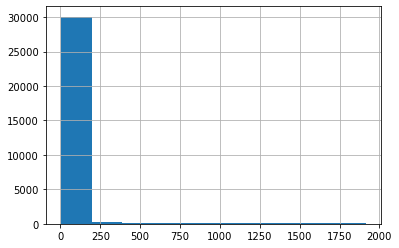

In [219]:
pd.Series(y_hat_train).hist()

<AxesSubplot:>

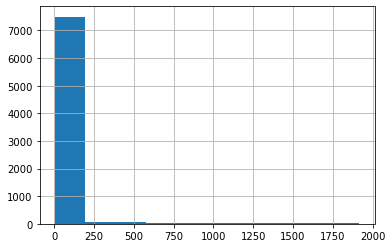

In [220]:
pd.Series(y_hat_test).hist()

<AxesSubplot:>

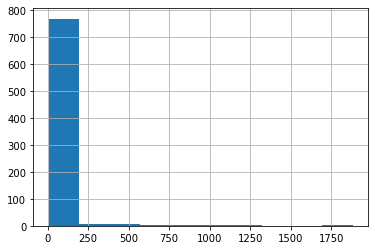

In [221]:
pd.Series(true_test_preds).hist()

### Evaluation 
- Accounting for 99% of cost 

## Box Plot 

In [264]:
X_cols

['dayPart',
 'originLocation',
 'destinationLocation',
 'distance',
 'weight',
 'carrier',
 'month']

In [277]:
clean_df['cost'].describe()

count    38999.000000
mean        80.972210
std        180.715055
min          5.000000
25%         38.768742
50%         46.468476
75%         70.239797
max       2019.734797
Name: cost, dtype: float64

## Future work 

/Users/litzysalazar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


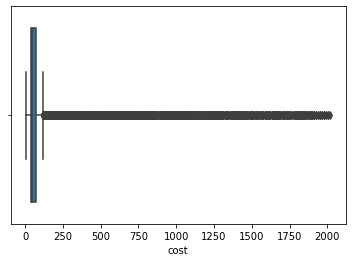

In [279]:
sns.boxplot(clean_df['cost'])
plt.show()

/Users/litzysalazar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


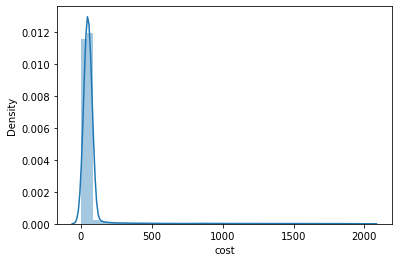

In [280]:
sns.distplot(clean_df['cost'])
plt.show()

In [283]:
Q1 = clean_df['cost'].quantile(0.25)

In [286]:
Q3 = clean_df['cost'].quantile(0.75)

In [287]:
IQR = Q3 - Q1

In [289]:
IQR

31.47105577

Text(0.5, 1.0, 'Cost each month')

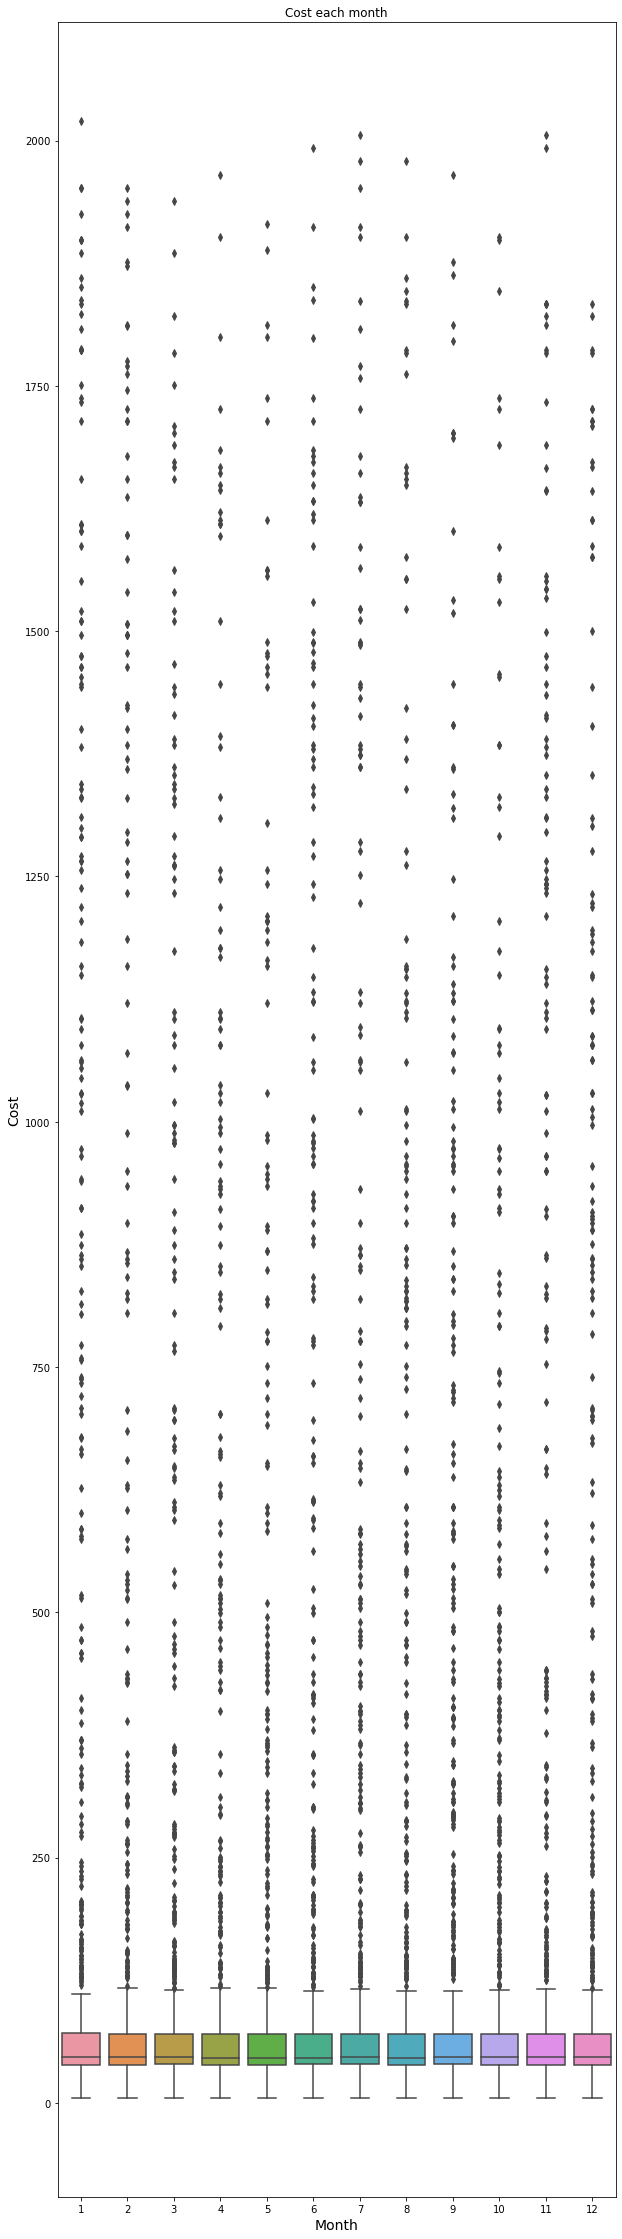

In [272]:
plt.figure(figsize=(10, 40))
sns.boxplot(x="month", 
            y="cost", 
            data=clean_df)
plt.ylabel("Cost", size=14)
plt.xlabel("Month", size=14)
plt.title("Cost each month")

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem.

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?
- For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding 

What does a baseline, model-less prediction look like?

In [ ]:
clean_df.head()

In [ ]:
# multiple regression - numerical features
# looking into data 
numerical_features_data = sns.load_dataset('clean_df').drop(['trip', 'dayPart', 'originLocation', 'destinationLocation', 'carrier'], axis=1)

### First ___ Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [ ]:
# code here for your first 'substandard' model

In [ ]:
# code here to evaluate your first 'substandard' model

### Explore Model Types 

Explore more model types, using fundamentally different algorithms to see how well they fit the data.

For example, if you chose to run a decision tree as your first ___ model, you may try a linear/logistic regression
next to see how it performs.

In [ ]:
# code here for a different model type

In [ ]:
# code here to evaluate that different model

### Model Choice & Modeling Iterations

Choose which underlying type of model works best, given your initial modeling and your understanding of the data/business problem. This might boil down to deciding whether tree-based or linear model would work best. After making this choice, focus only on models within that family of models (for example, if tree-based models work well and make sense in context, could explore random forests next).

Now you can start to use the results of your first model to iterate - there are many options! Explore hyperparameters and feature selection/feature engineering!

In [ ]:
# code here to iteratively improve your models

In [ ]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

## Conclusion

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?